# **Online Retail II Müşteri Segmentasyonu ve Satış Tahmini**
## İçerik
* Veri Analizi ve Ön İşleme
* Müşteri Segmentasyonu
* Satış Tahmini Modeli Geliştirme
* Model Sonuçlarının Değerlendirilmesi
* En İyi Modelin Seçimi
* Modele Etkisi Yüksek Olan Özelliklerin Gösterimi


## Gerekli Kütüphanelerin Yüklenmesi

In [1]:
!pip install shap -q
!pip install catboost -q
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


## Kullanacağımız kütüphaneleri projemize aktarıyoruz.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import RobustScaler,OneHotEncoder
from time import time

## Verilerimizi Projemize aktarıyoruz

In [3]:
# Kaggle üzerinde iki adet csv olarakta yükleyebilirdik fakat ben tek dosya üzerinde çalışmayı tercih ettim.
with pd.ExcelFile('/content/drive/MyDrive/DBrain/online_retail_II.xlsx') as file:
  print(file.sheet_names)
  sheets = file.sheet_names

['Year 2009-2010', 'Year 2010-2011']


In [4]:
retail_2009_2010 = pd.read_excel('/content/drive/MyDrive/DBrain/online_retail_II.xlsx',sheet_name=sheets[0])
retail_2010_2011 = pd.read_excel('/content/drive/MyDrive/DBrain/online_retail_II.xlsx',sheet_name=sheets[1])

## Veri analizinde kullanılmak üzere kullanacağımız fonksiyonlarımızı yazıyoruz.
# Explain DF
* Veri Boyutu
* Sütundaki veri tipleri
* Sayısal Verilerin istatiksel bilgileri
* Kayıp Veri Sayıları ve Oranı
* İlk 5 veri

# Check Outliers
* Var olan aykırı değer içeren sütunları ve değerleri gösterir.

# Missing Pie
* Kayıp verileri pasta grafiği üzerinde gösterir.

In [5]:
def explain_df(dataframe):
  print(f"{'#'*5} SHAPE {'#'*5}",end='\n\n')
  print(dataframe.shape,end='\n\n\n')
  print(f"{'#'*5} TYPES {'#'*5}",end='\n\n')
  print(dataframe.info(),end='\n\n\n')
  print(f"{'#'*5} Statistical Info For Numerical Columns {'#'*5}",end='\n\n')
  print(dataframe.describe().T,end='\n\n\n')
  print(f"{'#'*5} Num. of Missing {'#'*5}",end='\n\n')
  print(dataframe.isnull().sum(),end='\n\n\n')
  print(f"{'#'*5} Ratio of Missing {'#'*5}",end='\n\n')
  print(dataframe.isnull().mean() *100,end='\n\n\n')
  print(f"{'#'*5} First 5 Rows {'#'*5}",end='\n\n')
  print(dataframe.head(),end='\n\n\n')


In [6]:
def check_outliers(df):
  for col in df.select_dtypes('number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    if len(outliers) > 0:
      print(f"{col} sütunu aykırı değere sahip",end='\n')
      print(f"Aykırı değerler: {outliers}",end='\n\n\n')

In [7]:
def missing_pie(df):
  missing_data = df.isnull().sum()
  missing_data = missing_data[missing_data > 0]
  plt.figure(figsize=(8,6))
  plt.pie(x=missing_data,labels=missing_data.index,autopct='%1.1f%%',pctdistance=1.25, labeldistance=.6)
  plt.title(f'Kayıp Veri Dağılımı - {len(df)} Veri Üzerinden')
  plt.show()

In [8]:
explain_df(retail_2009_2010)

##### SHAPE #####

(525461, 8)


##### TYPES #####

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None


##### Statistical Info For Numerical Columns #####

                count                           mean                  min  \
Quantity     525461.0                      10.337667              -9600.0   
InvoiceDate    525461  2010-06-28 11:37:36.

In [9]:
explain_df(retail_2010_2011)

##### SHAPE #####

(541910, 8)


##### TYPES #####

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


##### Statistical Info For Numerical Columns #####

                count                           mean                  min  \
Quantity     541910.0                       9.552234             -80995.0   
InvoiceDate    541910  2011-07-04 13:35:22.

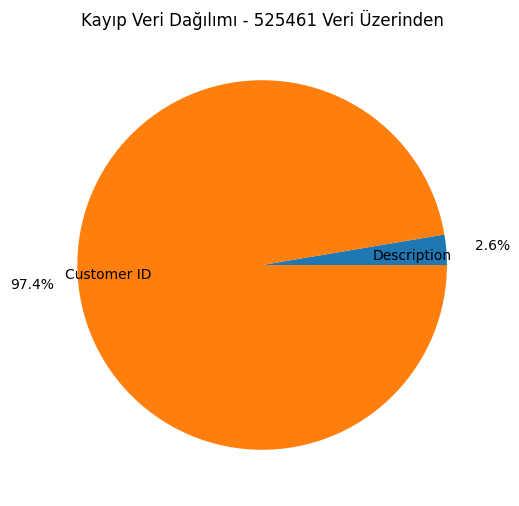

In [10]:
missing_pie(retail_2009_2010)

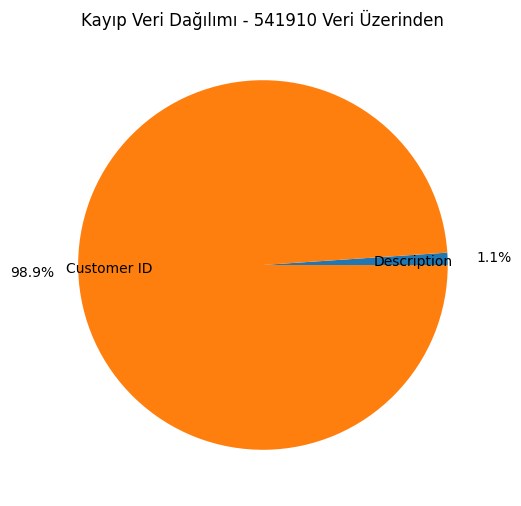

In [11]:
missing_pie(retail_2010_2011)

## Veri Ön İşleme
* Eksik verilerimizi veri setimizden kaldırıyoruz. Çoğu eksik veri müşteri kimliği kısmında bulunmaktadır. Müşteri kimliği istatiksel yol ile dolduralamayacağından ve müşterilerimizi sınıflandırırken işimize yaramadığından siliyoruz.

* Ürün Miktarı ve Ürün Fiyatı 0'dan küçük olan verilerimizi bilgi kirliliği yapmaması için siliyoruz.

* Müşteri analizini alım üzerinden yapacağımız için alım iptali yapan müşterilimizide siliyoruz.

* Aykırı değer içeren sütun ve değerleri inceliyoruz. Ürün sayıları ve Ürün fiyatları pahallı bir ürün veya fazla satılmış bir ürün olabileceğinden değerlerimize dokunmuyoruz.

In [12]:
retail_2010_2011 = retail_2010_2011.dropna()
retail_2009_2010 = retail_2009_2010.dropna()
retail_df = pd.concat([retail_2009_2010,retail_2010_2011])
retail_df = retail_df[(retail_df['Quantity']>0) & (retail_df['Price']>0)]
retail_df = retail_df[~retail_df['Invoice'].astype(str).str.contains('c',regex=False)]

In [13]:
check_outliers(retail_df)

Quantity sütunu aykırı değere sahip
Aykırı değerler: 3         48
54        28
55        30
56        30
57        30
          ..
541835    40
541865    40
541866    36
541867    72
541868    48
Name: Quantity, Length: 51983, dtype: int64


Price sütunu aykırı değere sahip
Aykırı değerler: 22         8.50
35         9.95
38         8.95
88         7.95
89        18.00
          ...  
541786    11.95
541831     8.50
541852     9.95
541892     8.95
541909    18.00
Name: Price, Length: 67346, dtype: float64




## Veri Ön işleme - 2
* Stok Sayısı ve Sadece bir ürün tipi içeren stokları alıyoruz.
* Bir ürün için ödenen toplam miktarı hesaplıyoruz.
* En son alım yapılan günün 1 gün sonrasına bir kontrol noktası ekliyoruz. Bu nokta alım tarihine göre en güncel alım yapan müşterileri tespit etmemizde yardımcı olacak.


In [14]:
product_stocks = retail_df[['Description','StockCode']].drop_duplicates()
stock_counts = product_stocks.groupby('Description').agg({'StockCode':'count'}).reset_index()
stock_counts = stock_counts[stock_counts['StockCode']>1]
retail_df = retail_df[~retail_df['Description'].isin(stock_counts['Description'])]
desc_count = product_stocks.groupby('StockCode').agg({'Description':'count'}).reset_index()
desc_count = desc_count[desc_count['Description']>1]
retail_df = retail_df[~(retail_df['StockCode'].isin(desc_count['StockCode'])) & ~(retail_df['StockCode'] == 'POST')]
retail_df.loc[:,'total_price'] = retail_df['Quantity'] * retail_df['Price']
last_transaction_time = retail_df['InvoiceDate'].max() + pd.Timedelta(days=1)

<ipython-input-14-22d21b767ba6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df.loc[:,'total_price'] = retail_df['Quantity'] * retail_df['Price']


In [15]:
last_transaction_time

Timestamp('2011-12-10 12:50:00')

## Müşteri Segmentasyonu

* Müşterilerin En Son Alım Tarihine Göre Puanlanması (Recency)

* Müşterinin Alım Sıklığına Göre Puanlanması (Frequency)

* Müşterinin Harcadığı Para Miktarına Göre Sıralanması (Monetary)
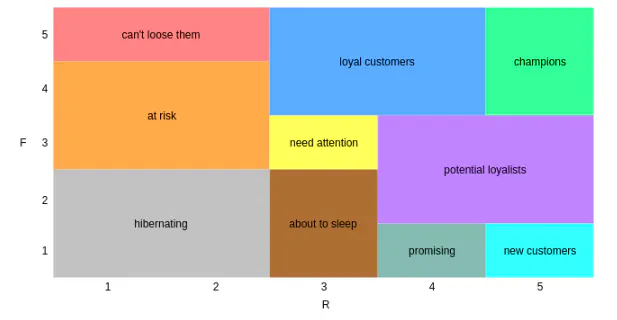

In [16]:
# RFM değerlerinin hesaplanması
rfm = retail_df.groupby('Customer ID').agg(
    {
        'InvoiceDate': lambda x: (last_transaction_time - x.max()).days,
        'Invoice': lambda x: x.nunique(),
        'total_price': lambda x:x.sum()
    }
)

In [17]:
# Sütun isimlerinin güncellenmesi
rfm = rfm.rename(columns={
    'InvoiceDate':'Recency',
    'Invoice':'Frequency',
    'total_price':'Monetary'
})

In [18]:
# RFM değerlerinin 5 adet aralığa bölünmesi ve aralıkların puanlanması
rfm['recency_rank'] = pd.qcut(rfm['Recency'],5,[5,4,3,2,1])
rfm['frequency_rank'] = pd.qcut(rfm['Frequency'].rank(method='first'),5,[1,2,3,4,5])
rfm['monetary_rank'] = pd.qcut(rfm['Monetary'],5,[1,2,3,4,5])
rfm['rf'] = rfm['recency_rank'].astype(str) + rfm['frequency_rank'].astype(str)
rfm['rfm_score'] = round(rfm[['recency_rank','frequency_rank','monetary_rank']].sum(axis=1) / 3,2)

In [19]:
# Puanlanan aralıklara göre müşterilerin segmentleri
rfm_map = {
    r'[1-2][1-2]':'hibernating', # Kış uykusunda
    r'[1-2][3-4]':'at_risk', # Geri kazanılma ihtimali olan müşteriler
    r'[1-2]5':'cant_loose_them', # Kaybedilmemesi gereken müşteriler
    r'3[1-2]':'about_to_sleep', # Kaybedilmek üzere olan müşteriler
    r'33':'need_attention', # Dikkat edilmesi gereken müşteriler
    r'[3-4][4-5]':'loyal_customers', # Sadık Müşteriler
    r'[4-5][2-3]':'potential_loyalists', # Sadık müşteri olma potansiyeli içeren müşteriler
    r'41':'promising', # Şampiyon olmaya yakın müşteriler
    r'51':'new_customers', # Yeni müşteriler
    r'5[4-5]':'champions' # Yüksek fiyat ile sık harcama yapan müşterileri
}

In [20]:
rfm['segment'] = rfm['rf'].replace(rfm_map,regex=True)
rfm = rfm.reset_index()

In [21]:
segments_df = rfm.groupby('segment').agg({'Customer ID':'count','Recency':'mean','Frequency':'mean','Monetary':'mean'}).rename(columns={
    'Customer ID':'num_customers',
    'Recency':'avg_recency',
    'Frequency':'avg_frequency',
    'Monetary':'avg_monetary'
})

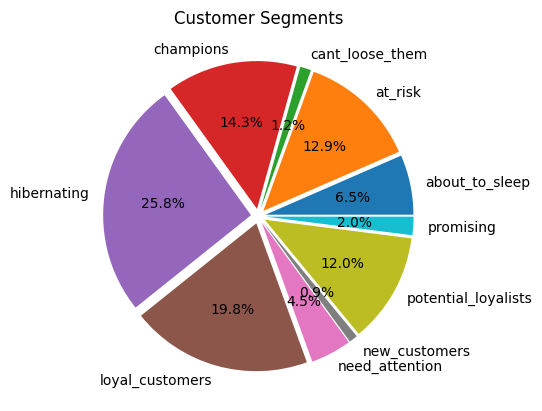

In [22]:
plt.pie(x='num_customers',labels=segments_df.index,data=segments_df,autopct='%1.1f%%',explode = [0.05]*len(segments_df.index))
plt.title('Customer Segments')
plt.show()

In [23]:
segments_df

,num_customers,avg_recency,avg_frequency,avg_monetary
segment,,,,
about_to_sleep,381,107.425197,1.343832,402.063367
at_risk,753,372.657371,3.826029,1154.347503
cant_loose_them,70,328.528571,15.642857,4938.159457
champions,831,8.613718,18.803851,7799.851570
hibernating,1504,457.978059,1.247340,339.547109
loyal_customers,1154,66.758232,9.599653,3047.250411
need_attention,260,112.376923,3.092308,820.533038
new_customers,55,10.509091,1.000000,293.296000
potential_loyalists,701,25.743224,2.570613,972.787434


## Müşterilerin Segmentine, harcadığı para miktarına ve harcama sıklığına göre dağılımı

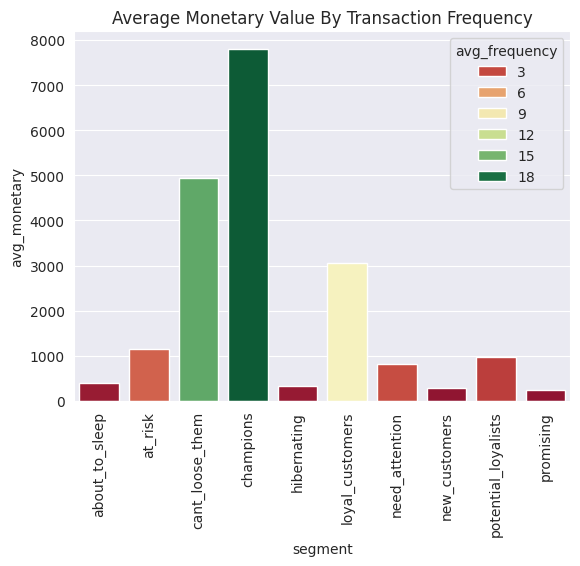

In [24]:
sns.set_style('darkgrid')
pal=sns.color_palette('RdYlGn',len(segments_df),as_cmap=True)
sns.barplot(x='segment',y='avg_monetary',data=segments_df,capsize=4,hue='avg_frequency',palette=pal)
plt.xticks(rotation=90)
plt.title('Average Monetary Value By Transaction Frequency')
plt.show()

In [25]:
rfm[['segment','Recency','Frequency','Monetary']].groupby('segment').agg(['mean','count','sum'])

Recency                Frequency               \
                           mean count     sum       mean count    sum   
segment                                                                 
about_to_sleep       107.425197   381   40929   1.343832   381    512   
at_risk              372.657371   753  280611   3.826029   753   2881   
cant_loose_them      328.528571    70   22997  15.642857    70   1095   
champions              8.613718   831    7158  18.803851   831  15626   
hibernating          457.978059  1504  688799   1.247340  1504   1876   
loyal_customers       66.758232  1154   77039   9.599653  1154  11078   
need_attention       112.376923   260   29218   3.092308   260    804   
new_customers         10.509091    55     578   1.000000    55     55   
potential_loyalists   25.743224   701   18046   2.570613   701   1802   
promising             38.991453   117    4562   1.000000   117    117   

                        Monetary                     
                            mean count          sum  
segment                                              
about_to_sleep        402.063367   381   153186.143  
at_risk              1154.347503   753   869223.670  
cant_loose_them      4938.159457    70   345671.162  
champions            7799.851570   831  6481676.655  
hibernating           339.547109  1504   510678.852  
loyal_customers      3047.250411  1154  3516526.974  
need_attention        820.533038   260   213338.590  
new_customers         293.296000    55    16131.280  
potential_loyalists   972.787434   701   681923.991  
promising             238.692564   117    27927.030

## Satış Tahmini

### Geliştirelecek model için özelliklerin çıkarılması (Feature Engineering)

In [26]:
retail_df['Year'] = retail_df['InvoiceDate'].dt.year
retail_df['Month'] = retail_df['InvoiceDate'].dt.month
retail_df['Day'] = retail_df['InvoiceDate'].dt.day
retail_df['Hour'] = retail_df['InvoiceDate'].dt.hour
retail_df['Minute'] = retail_df['InvoiceDate'].dt.minute
retail_df['Weekday'] = retail_df['InvoiceDate'].dt.weekday
retail_df['is_weekend'] = retail_df['Weekday'].apply(lambda x:1 if x>=5 else 0)
retail_df['is_holiday_season'] = retail_df['Month'].apply(lambda x:1 if x in [6,7,8] else 0)

retail_df['avg_quantity_by_customer'] = retail_df.groupby('Customer ID')['Quantity'].transform('mean').round(2)
retail_df['avg_price_by_customer'] = retail_df.groupby('Customer ID')['Price'].transform('mean').round(2)
retail_df['avg_quantity_by_product'] = retail_df.groupby('Description')['Quantity'].transform('mean').round(2)
retail_df['avg_quantity_by_transcation'] = retail_df.groupby('Invoice')['Quantity'].transform('mean').round(2)
retail_df['avg_price_by_transcation'] = retail_df.groupby('Invoice')['Price'].transform('mean').round(2)
retail_df['total_quantity_by_date'] = retail_df.groupby('InvoiceDate')['Quantity'].transform('sum')
retail_df['total_price_by_date'] = retail_df.groupby('InvoiceDate')['Price'].transform('sum')

In [27]:
retail_df = retail_df.drop(['Invoice','StockCode','Description','InvoiceDate','Customer ID'],axis=1)

In [28]:
retail_df

,Quantity,Price,Country,total_price,Year,Month,Day,Hour,Minute,Weekday,is_weekend,is_holiday_season,avg_quantity_by_customer,avg_price_by_customer,avg_quantity_by_product,avg_quantity_by_transcation,avg_price_by_transcation,total_quantity_by_date,total_price_by_date
0,12,6.95,United Kingdom,83.40,2009,12,1,7,45,1,0,0,11.79,2.90,5.65,24.00,3.74,120,18.70
1,12,6.75,United Kingdom,81.00,2009,12,1,7,45,1,0,0,11.79,2.90,9.71,24.00,3.74,120,18.70
3,48,2.10,United Kingdom,100.80,2009,12,1,7,45,1,0,0,11.79,2.90,21.32,24.00,3.74,120,18.70
5,24,1.65,United Kingdom,39.60,2009,12,1,7,45,1,0,0,11.79,2.90,12.31,24.00,3.74,120,18.70
6,24,1.25,United Kingdom,30.00,2009,12,1,7,45,1,0,0,11.79,2.90,17.68,24.00,3.74,120,18.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541900,4,3.75,France,15.00,2011,12,9,12,50,4,0,0,9.06,2.93,5.53,6.56,3.17,59,28.55
541902,12,1.95,France,23.40,2011,12,9,12,50,4,0,0,9.06,2.93,17.81,6.56,3.17,59,28.55
541904,12,0.85,France,10.20,2011,12,9,12,50,4,0,0,9.06,2.93,12.61,6.56,3.17,59,28.55
541907,4,4.15,France,16.60,2011,12,9,12,50,4,0,0,9.06,2.93,6.69,6.56,3.17,59,28.55


### Hedef sütunun seçilmesi ve ön işleme aşamaları
* Kategorik verileri One Hot Encoding ile sayısal hale çeviriyoruz.
* Sayısal verilerimizi ise Aykırı değerleri olduğundan RobustScaler ile ölçeklendiriyoruz.
* %80 Eğitim ve %20 Test verisi olarak ayırıyoruz.
* En iyi modeli bulmak için optuna kütüphanesine kullanılacak modelleri ve parametreleri veriyoruz.
* En iyi modeli test verisi üzerinde test ediyoruz.
* Model eğitiminde kullanılan özellikleri önem sırasına göre sıralıyoruz.

In [29]:
cat_cols = retail_df.select_dtypes('object').columns
num_cols = retail_df.select_dtypes('number').columns
num_cols = num_cols.drop('total_quantity_by_date')
cat_cols

Index(['Country'], dtype='object')

In [30]:
cat_transformer = ColumnTransformer([
    ('encoder',OneHotEncoder(),cat_cols)
],remainder='passthrough')
num_transformer = ColumnTransformer([
    ('scaler',RobustScaler(),num_cols)
])

preprocess_transformer = ColumnTransformer([
    ('cat',cat_transformer,cat_cols),
    ('num',num_transformer,num_cols)
])

X=retail_df.drop('total_quantity_by_date',axis=1)
y=retail_df['total_quantity_by_date']

X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [31]:
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['catboost', 'xgboost'])

    if model_type == 'catboost':
        param = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'depth': trial.suggest_int('depth', 1, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'random_strength': trial.suggest_int('random_strength', 0, 100),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 100.00),
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'od_wait': trial.suggest_int('od_wait', 10, 50)
        }
        model = CatBoostRegressor(**param, verbose=0)

    elif model_type == 'xgboost':
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0)
        }
        model = XGBRegressor(**param, verbosity=0)

    pipeline = Pipeline([
        ('preprocess',preprocess_transformer),
        ('regressor', TransformedTargetRegressor(
        regressor=model,
        func=np.log,
        inverse_func=np.exp
    ))
    ])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=600)

print('En iyi hiperparametreler: ', study.best_params)

[I 2024-07-17 12:26:12,621] A new study created in memory with name: no-name-20c62b1e-c953-44f8-b7e8-84e5bdacf461
[I 2024-07-17 12:26:26,217] Trial 0 finished with value: 827.0286987676724 and parameters: {'model_type': 'xgboost', 'n_estimators': 157, 'max_depth': 4, 'learning_rate': 0.1427878348761568, 'colsample_bytree': 0.4681804571155527, 'subsample': 0.6459441800262326, 'reg_alpha': 2.5234477921093506, 'reg_lambda': 7.200044992181771}. Best is trial 0 with value: 827.0286987676724.
[I 2024-07-17 12:27:20,088] Trial 1 finished with value: 724.3615517116535 and parameters: {'model_type': 'catboost', 'iterations': 312, 'depth': 9, 'learning_rate': 0.12021839480281757, 'random_strength': 89, 'bagging_temperature': 39.578417043705045, 'od_type': 'Iter', 'od_wait': 16}. Best is trial 1 with value: 724.3615517116535.
[I 2024-07-17 12:28:25,514] Trial 2 finished with value: 936.821567212534 and parameters: {'model_type': 'catboost', 'iterations': 130, 'depth': 12, 'learning_rate': 0.06449

En iyi hiperparametreler:  {'model_type': 'xgboost', 'n_estimators': 776, 'max_depth': 7, 'learning_rate': 0.21200542831998603, 'colsample_bytree': 0.6655239682282186, 'subsample': 0.9488627924232518, 'reg_alpha': 1.6967274344277785, 'reg_lambda': 3.0325640507998233}


In [32]:
best_params = study.best_params
best_params.pop('model_type',None)
best_params

{'n_estimators': 776,
 'max_depth': 7,
 'learning_rate': 0.21200542831998603,
 'colsample_bytree': 0.6655239682282186,
 'subsample': 0.9488627924232518,
 'reg_alpha': 1.6967274344277785,
 'reg_lambda': 3.0325640507998233}

In [33]:
%%time
pipeline = Pipeline([
    ('preprocess',preprocess_transformer),
    ('regressor', TransformedTargetRegressor(regressor=XGBRegressor(**best_params)))
])

start_time = time()
pipeline.fit(X_train,y_train)
end_time = time()

print(f'Model eğitime süresi: {end_time - start_time} saniye')

Model eğitime süresi: 66.40900993347168 saniye
CPU times: user 1min 49s, sys: 586 ms, total: 1min 49s
Wall time: 1min 6s


In [34]:
score = pipeline.score(X_test,y_test)
score

0.9806982930263172

In [35]:
X_test = preprocess_transformer.transform(X_test)

In [36]:
features = pipeline[0].get_feature_names_out()

In [37]:
sample = X_test[:10000,]
sample.shape

(10000, 58)

In [38]:
explainer = shap.Explainer(pipeline[1].regressor_)
shap_values = explainer(sample)

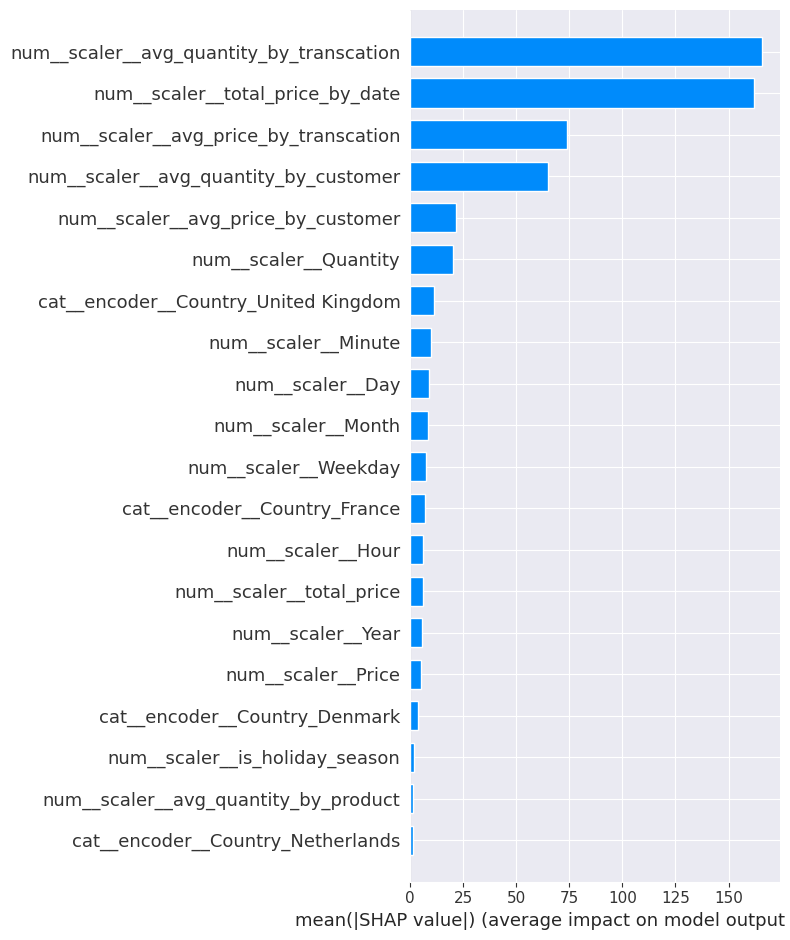

In [39]:
shap.summary_plot(shap_values,X_test,plot_type='bar',feature_names=features)